# Exercise 5

Welcome to the fifth challenge! The goal of this exercise is to create an agent that can read weekly reports in a PDF format and then analyze them for you. More specifically, in this exercise we want the agent to generate a chart depicting the weekly drought conditions based on 6 weekly reports.

## Setup
Let's start by importing the libraries that we will need.

In [2]:
import os

from crewai import Agent, Crew, Task
from crewai_tools import BaseTool, DirectoryReadTool
from dotenv import load_dotenv
from pypdf import PdfReader

Before you execute this cell, make sure to provide the environment variables `OPENAI_API_BASE`, `OPENAI_MODEL_NAME`, and `OPENAI_API_KEY` in the `.env` file.

In [3]:
load_dotenv(override=True)

model_name = os.environ.get("OPENAI_MODEL_NAME", "No model specified in .env file")
print("Using the following LLM model:", model_name)

Using the following LLM model: gpt-4o-2024-08-06


## Tools

In [4]:
class OCRTool(BaseTool):
    name: str = "Perform OCR"
    description: str = "Performs OCR on a PDF file and returns the content as a list of strings, each list entry representing one page of the document"

    def _run(self, path: str) -> list[str]:
        reader = PdfReader(path)
        content = []

        for page in reader.pages:
            content.append(page.extract_text())
        
        return content

    def cache_function(*args):
        return False

directory_read_tool = DirectoryReadTool("./reports/")
ocr_tool = OCRTool()

## Agents

In [5]:
data_scientist = Agent(
    role="Senior Python Data Analyst",
    goal="Analyze data and provide insights using Python",
    backstory="You are an experienced data analyst with strong Python skills.",
    allow_code_execution=True,
    tools=[directory_read_tool, ocr_tool],
    cache=False,
    verbose=True,
)

## Tasks

In [16]:
data_extraction = Task(
    description="Read the weekly drought reports and extract the date of the week and the corresponding drought condition.",
    expected_output="A list with a bullet point for each week stating the date and the drought condition",
    agent=data_scientist,
)


coding = Task(
    description="Create a chart showing the development of the drought conditions across the weeks. Do not show the plot but save it as base64 encoded text. Finally, print the base64 encoded plot to the stdout.",
    expected_output="A text representing a base 64 encoded image of a plot",
    agent=data_scientist,
    output_file="plot.b64"
)

## Kicking off the Crew

In [17]:
from langchain_openai import ChatOpenAI


crew = Crew(
    agents=[data_scientist],
    tasks=[data_extraction, coding],
    cache=False,
    planning=True,
    planning_llm=ChatOpenAI(model="gpt-4o-2024-08-06"),
)
result = crew.kickoff()

print(result.raw)

2024-09-03 20:55:06,808 - 8078364672 - __init__.py-__init__:531 - WARNING: Overriding of current TracerProvider is not allowed


 Error parsing JSON: Expecting value: line 1 column 1 (char 0). Attempting to handle partial JSON.


> Entering new CrewAgentExecutor chain...
To accomplish this task, I need to first list the files in the directory `./reports/` to determine which files are available for processing. Once I have the list of files, I can then perform OCR on each PDF file to extract the content and analyze it to extract the date and drought condition.

Action: List files in directory
Action Input: {}
 

File paths: 
-./reports/weekly_drought_report_01_04_24.pdf
- ./reports/weekly_drought_report_04_03_24.pdf
- ./reports/weekly_drought_report_25_03_24.pdf
- ./reports/weekly_drought_report_11_03_24.pdf
- ./reports/weekly_drought_report_08_04_24.pdf
- ./reports/weekly_drought_report_18_03_24.pdf

Thought: Now that I have the list of PDF files, I will perform OCR on each of these files to extract the content. This will allow me to find the dates and drought conditions for each week.

Action: Perform OCR
Action

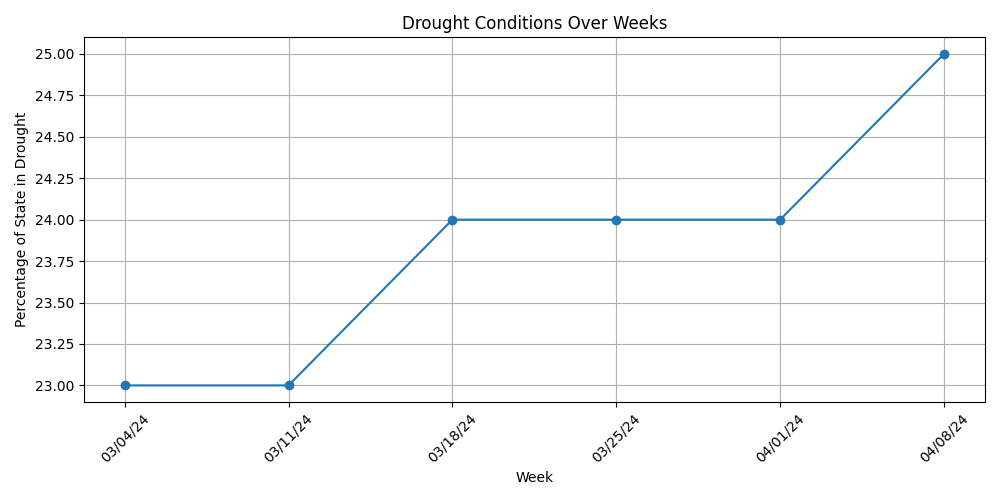

In [23]:
from IPython import display
from base64 import b64decode

with open("plot.b64", "r", encoding="utf-8") as file:
    file_content = file.read()

display.Image(b64decode(file_content))